In [17]:
import sys
from pathlib import Path

# Lấy thư mục làm việc hiện tại
current_dir = Path.cwd()

# Đi lên một cấp
parent_dir = current_dir.parent

sys.path.insert(0, str(parent_dir))


In [18]:
import base64
from typing import Annotated, List, Union

# import magic
import requests
from IPython.display import Image, display
from langchain_community.tools import (
    ArxivQueryRun,
    DuckDuckGoSearchResults,
    WikipediaQueryRun,
)
from langchain_community.utilities import (
    ArxivAPIWrapper,
    DuckDuckGoSearchAPIWrapper,
    WikipediaAPIWrapper,
)
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, create_react_agent, tools_condition
from pydantic import BaseModel, Field
from typing_extensions import TypedDict


from typing import Optional

from langchain_core.callbacks import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain_core.tools import BaseTool
from langchain_core.tools import tool
from langchain_core.tools.base import ArgsSchema
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
from tools.dam import run_full_image_vqa
import operator
# from ultralytics import YOLO

In [19]:
llm: ChatOpenAI = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    temperature=0,
    api_key="not-needed"
)

## Tools

### KBs tools

In [20]:
arxiv_wrapper = ArxivAPIWrapper(
    top_k_results=2, doc_content_chars_max=1000
)
arxiv = ArxivQueryRun(
    api_wrapper=arxiv_wrapper,
    description="Search for papers on a given topic using Arxiv"
)
# arxiv.invoke("Rotary Positional Encoding")
wikipedia_wrapper = WikipediaAPIWrapper()
wikipedia = WikipediaQueryRun(
    api_wrapper=wikipedia_wrapper,
    description="Search for information on a given topic using Wikipedia"
)
# wikipedia.invoke("machine learning")
duck_search = DuckDuckGoSearchResults(output_format="list")
# duck_search.invoke("Rotary Positional Encoding")

### VQA tool

In [21]:
from langchain_core.tools import tool

@tool
def vqa_tool(image_url: str, questin: str) -> str:
    """return the candidate answer with probability of the question"""
    return run_full_image_vqa(image_url, question)


In [22]:
tools = [arxiv, wikipedia, duck_search, vqa_tool]
tools_by_name = {tool.name: tool for tool in tools}

tools_by_name

{'arxiv': ArxivQueryRun(description='Search for papers on a given topic using Arxiv', api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=2, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=1000)),
 'wikipedia': WikipediaQueryRun(description='Search for information on a given topic using Wikipedia', api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\Asus\\App\\miniconda\\workspace\\envs\\MAknowledge\\lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)),
 'duckduckgo_results_json': DuckDuckGoSearchResults(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text'), output_format='list'),
 'vqa_t

## Generate Agent

### State

In [23]:
class Analyst(BaseModel):
    name: str = Field(
        description="Name of the analyst."
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    tools: List[str]
    
    @property
    def affiliation(self) -> str:
        return f"{self.name} Agent for VQA"
    
    @property
    def persona(self) -> str:
        return f"Name: {self.affiliation}\nTools: {self.tools}\nDescription: {self.description}"

In [24]:
class GenerateAnalystsState(TypedDict):
    question: str
    image: str
    analysts: List[Analyst] 

### Node

In [25]:
def create_analysts(state: GenerateAnalystsState):
    analyst_specs = {
        "junior": {
            "name": "Junior",
            "description": "A junior analyst who uses only the vanilla VQA model to generate candidate answers.",
            "tools": ["vqa_tool"],
            "system_prompt": """You are junior analyst. Please provide the actions for the given task.
                                ===
                                The actions should be in [Action_1].
                                Action_1 (vqa_tool) is that you need to refer candidate answers to answer questions.
                                ===
                                task: {task}
                                the response should be like this: Action_1
                            """
        },
        "senior": {
            "name": "Senior",
            "description": "A senior analyst who uses both the VQA model and KBs retrieval to enhance answers.",
            "tools": ["vqa_tool", "arxiv", "wikipedia", "duckduckgo_results_json"],
            "system_prompt": """You are junior analyst. Please provide the actions for the given task.
                        ===
                        The actions should be in [Action_1, Action_2, Action_3].
                        Action_1 (vqa_tool) is that you need to refer candidate answers to answer questions.
                        Action_2 (arxiv, wikipedia) is that you need retrieve knowledge from KBs to answer questions.
                        ===
                        task: {task}
                        the response should be like this: Action_1, Action_2
                    """
        },
        # "manager": {
        #     "name": "Manager",
        #     "description": "A manager analyst with access to all tools including LLM-based knowledge generation.",
        #     "tools": ["arxiv", "wikipedia", "duckduckgo_results_json"]
        # }
    }

    # Tạo list các Analyst object
    analysts = [Analyst(**spec) for spec in analyst_specs.values()]

    return {"analysts": analysts}

### Build graph

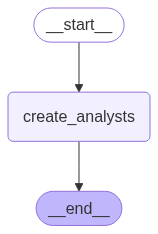

In [26]:
# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", END)

# Compile
memory = MemorySaver()
gen_analysis_graph = builder.compile(checkpointer=memory)

# View
display(Image(gen_analysis_graph.get_graph(xray=1).draw_mermaid_png()))

In [27]:
thread = {"configurable": {"thread_id": "1"}}
analysts = gen_analysis_graph.invoke({"question": "What color is the dog's fur?"}, thread)

In [28]:
analysts["analysts"][1]

Analyst(name='Senior', description='A senior analyst who uses both the VQA model and KBs retrieval to enhance answers.', tools=['vqa_tool', 'arxiv', 'wikipedia', 'duckduckgo_results_json'])

## Visual-research Agent

### State

In [29]:
class ViReAgentState(MessagesState):
    question: str
    image: str
    analysts: List[Analyst]
    results: Annotated[List[str], operator.add] = []


class ViReJuniorState(MessagesState):
    question: str
    image: str
    analyst: Analyst
    number_of_steps: int = 0
    answer_candidate: Optional[str] = ""
    LLM_Knowledge: Optional[str] = ""
    KBs_Knowledge: Annotated[List[str], operator.add] = []

class ViReSeniorState(MessagesState):
    question: str
    image: str
    analyst: Analyst
    number_of_steps: int = 0
    KBs_Knowledge: Annotated[List[str], operator.add] = []

class ViReManagerState(MessagesState):
    question: str
    image: str
    analyst: Analyst
    number_of_steps: int = 0
    answer_candidate: Optional[str] = ""
    KBs_Knowledge: Annotated[List[str], operator.add] = []
    LLM_Knowledge: Optional[str] = ""


### Node

In [30]:
from langchain_core.runnables import RunnableConfig
import json
from langchain_core.messages import ToolMessage


def tool_node(state: Union[ViReJuniorState, ViReSeniorState, ViReManagerState]):
    outputs = []
    tool_calls = state["messages"][-1].tool_calls
    print(f"Processing {len(tool_calls)} tool calls")
    
    updates = {"messages": outputs}
    
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        
        try:
            if tool_name == "vqa":
                result = vqa_tool(tool_call["args"])
                updates["answer_candidate"] = result
                
            elif tool_name in ["arxiv", "wikipedia", "duckduckgo_results_json"]:
                result = tools_by_name[tool_name].invoke(tool_call["args"])
                if "KBs_Knowledge" not in updates:
                    updates["KBs_Knowledge"] = []
                
                if isinstance(result, str):
                    updates["KBs_Knowledge"].append(result)
                elif isinstance(result, list):
                    updates["KBs_Knowledge"].extend(result)
                    
            else:
                result = f"Unknown tool: {tool_name}"
            
            outputs.append(
                ToolMessage(
                    content=json.dumps(result),
                    name=tool_name,
                    tool_call_id=tool_call["id"],
                )
            )
            
        except Exception as e:
            print(f"Error processing tool {tool_name}: {e}")
            outputs.append(
                ToolMessage(
                    content=f"Error: {str(e)}",
                    name=tool_name,
                    tool_call_id=tool_call["id"],
                )
            )
    
    return updates


# Define the node that calls the model
def call_vire_agent(
    state: Union[ViReJuniorState, ViReSeniorState, ViReManagerState],
    config: RunnableConfig,
):
    tools = state["analyst"].tools
    tools = [tools_by_name[tool] for tool in tools]
    llm: ChatOpenAI = ChatOpenAI(
        base_url="http://127.0.0.1:1234/v1",
        temperature=0,
        api_key="not-needed"
    ).bind_tools(tools)
    system_prompt = SystemMessage(
        content=state["analyst"].system_prompt
    )
    question_prompt = HumanMessage(content=f"question: {state['question']}")
    history = state.get("messages", [])
    sequence = [system_prompt, question_prompt] + history

    response = llm.invoke(sequence, config)
    return {"messages": [response]}


def final_reasoning_node(state: Union[ViReJuniorState, ViReSeniorState, ViReManagerState]):
    """Node cuối cùng để tổng hợp kết quả và đưa ra câu trả lời final"""
    
    # Tạo context từ các thông tin đã thu thập
    context_parts = []
    
    # Thêm answer_candidate nếu có (từ VQA)
    if hasattr(state, 'answer_candidate') and state.get("answer_candidate"):
        context_parts.append(f"Visual Analysis Result: {state['answer_candidate']}")
    
    # Thêm KBs_Knowledge nếu có
    if state.get("KBs_Knowledge"):
        kb_info = "\n".join(state["KBs_Knowledge"])
        context_parts.append(f"Knowledge Base Information:\n{kb_info}")
    
    # Thêm LLM_Knowledge nếu có
    if hasattr(state, 'LLM_Knowledge') and state.get("LLM_Knowledge"):
        context_parts.append(f"LLM Generated Knowledge: {state['LLM_Knowledge']}")
    
    # Tạo final reasoning prompt
    context = "\n\n".join(context_parts)
    
    final_system_prompt = f"""
    You are a {state['analyst'].name} analyst. Based on the information gathered from various tools, 
    provide a comprehensive and final answer to the user's question.
    
    Available Information:
    {context}
    
    Original Question: {state['question']}
    
    Instructions:
    1. Analyze all available information
    2. Synthesize the findings
    3. Provide a clear, concise final answer
    4. Explain your reasoning briefly
    """
    
    # LLM không cần tools cho final reasoning
    llm = ChatOpenAI(
        base_url="http://127.0.0.1:1234/v1",
        temperature=0.1,  # Hơi creative một chút cho final reasoning
        api_key="not-needed"
    )
    
    system_msg = SystemMessage(content=final_system_prompt)
    human_msg = HumanMessage(content="Please provide your final analysis and answer.")
    
    final_response = llm.invoke([system_msg, human_msg])
    
    return {
        "messages": [final_response],
        "results": [final_response.content],
        "number_of_steps": state.get("number_of_steps", 0) + 1
    }

def should_continue(state: Union[ViReJuniorState, ViReSeniorState, ViReManagerState]):
    messages = state["messages"]
    last_message = messages[-1]
    
    # Nếu không có tool calls, chuyển sang final reasoning
    if not last_message.tool_calls:
        return "final_reasoning"
    # Nếu có tool calls, tiếp tục với tools
    else:
        return "continue"

### Graph

In [31]:
from langgraph.graph import StateGraph, END

def create_junior_subgraph():
    """Tạo subgraph cho Junior Analyst"""
    workflow = StateGraph(ViReJuniorState)
    
    workflow.add_node("agent", call_vire_agent)
    workflow.add_node("tools", tool_node)
    workflow.add_node("final_reasoning", final_reasoning_node)
    
    workflow.set_entry_point("agent")
    workflow.add_conditional_edges("agent", should_continue, {
        "continue": "tools",
        "final_reasoning": "final_reasoning"
    })
    workflow.add_edge("tools", "agent")
    workflow.add_edge("final_reasoning", END)
    
    return workflow.compile()

def create_senior_subgraph():
    """Tạo subgraph cho Senior Analyst"""
    workflow = StateGraph(ViReSeniorState)
    
    workflow.add_node("agent", call_vire_agent)
    workflow.add_node("tools", tool_node)
    workflow.add_node("final_reasoning", final_reasoning_node)
    
    workflow.set_entry_point("agent")
    workflow.add_conditional_edges("agent", should_continue, {
        "continue": "tools",
        "final_reasoning": "final_reasoning"
    })
    workflow.add_edge("tools", "agent")
    workflow.add_edge("final_reasoning", END)
    
    return workflow.compile()

def create_manager_subgraph():
    """Tạo subgraph cho Manager Analyst"""
    workflow = StateGraph(ViReManagerState)
    
    workflow.add_node("agent", call_vire_agent)
    workflow.add_node("tools", tool_node)
    workflow.add_node("final_reasoning", final_reasoning_node)
    
    workflow.set_entry_point("agent")
    workflow.add_conditional_edges("agent", should_continue, {
        "continue": "tools",
        "final_reasoning": "final_reasoning"
    })
    workflow.add_edge("tools", "agent")
    workflow.add_edge("final_reasoning", END)
    
    return workflow.compile()


In [32]:
def route_to_analysts(state: ViReAgentState):
    """Router sử dụng Send API để phân phối song song"""
    sends = []
    
    for analyst in state["analysts"]:
        # Tạo state riêng cho mỗi analyst
        analyst_state = {
            "question": state["question"],
            "image": state["image"],
            "analyst": analyst,
            "number_of_steps": 0,
            "messages": []
        }
        
        # Send đến subgraph tương ứng
        if "junior" in analyst.name.lower():
            sends.append(Send("junior_subgraph", analyst_state))
        elif "senior" in analyst.name.lower():
            sends.append(Send("senior_subgraph", analyst_state))
        elif "manager" in analyst.name.lower():
            sends.append(Send("manager_subgraph", analyst_state))
    
    return sends

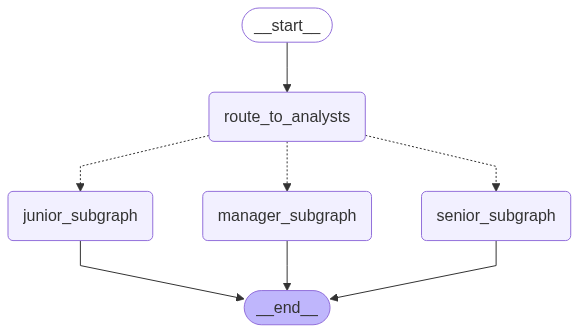

In [33]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

main_workflow = StateGraph(ViReAgentState)

# Add nodes
main_workflow.add_node("route_to_analysts", route_to_analysts)
main_workflow.add_node("junior_subgraph", create_junior_subgraph())
main_workflow.add_node("senior_subgraph", create_senior_subgraph())
main_workflow.add_node("manager_subgraph", create_manager_subgraph())
# main_workflow.add_node("aggregate_results", aggregate_results)

# Set entry point
main_workflow.add_edge(START, "route_to_analysts")

# Conditional edges từ router (Send API)
main_workflow.add_conditional_edges(
    "route_to_analysts",
    lambda x: "analysts",  # Dummy function vì Send API tự route
    ["junior_subgraph", "senior_subgraph", "manager_subgraph"]
)

# Tất cả subgraphs đều đi đến aggregation
main_workflow.add_edge("junior_subgraph", END)
main_workflow.add_edge("senior_subgraph", END)
main_workflow.add_edge("manager_subgraph", END)


# Compile
ViReAgent = main_workflow.compile()
display(Image(ViReAgent.get_graph().draw_mermaid_png()))

In [34]:
# agent = analysts["analysts"][1]
# # Create our initial message dictionary
# # "messages": [("user", "How is the weather in Vietnam?")] (optional)
# URL = "https://github.com/NVlabs/describe-anything/blob/main/images/1.jpg?raw=true"
# Q = "What color is the dog's fur?"
# inputs = {"analyst": agent, "question": Q, "image": URL}

# for state in ViReAgent.stream(inputs, stream_mode="values"):
#     if state["messages"]:
#         last_message = state["messages"][-1]
#         last_message.pretty_print()

## Router

In [35]:
def route_to_agents(state: ViReAgentState):
    """Phân phối input đến 3 agents song song"""
    sends = []
    
    # Tạo state riêng cho mỗi agent level
    junior_state = create_junior_state(state)
    senior_state = create_senior_state(state)  
    manager_state = create_manager_state(state)
    
    sends.extend([
        Send("junior_agent", junior_state),
        Send("senior_agent", senior_state),
        Send("manager_agent", manager_state)
    ])
    
    return sends